In [1]:
import os
from pathlib import Path

import reaktoro as rkt
import numpy as np
import matplotlib.pyplot as plt

DATABASE_DIR = Path(os.getenv("DATABASES"))

In [2]:
db = rkt.PhreeqcDatabase.fromFile(str(DATABASE_DIR / "Kinec_v3.dat"))
# db = rkt.PhreeqcDatabase("phreeqc.dat")  # lacks vaterite

In [3]:
# aqueous_solution = rkt.AqueousPhase("H2O H+ OH- HCO3- Ca+2 CO3-2 CO2 CaHCO3+")  # explicit species definition, if convenient
aqueous_solution = rkt.AqueousPhase(rkt.speciate("H O C Ca"))
# aqueous_solution.set(rkt.ActivityModelPhreeqc(db))
aqueous_solution.set(rkt.ActivityModelPitzer())  # most accurate for high ionic strength

# Use the below for Extended UNIQUAC, as in my paper.
# Note: no Aragonite or Vaterite parameters are available for E-UNIQUAC.
# db = rkt.Database.embedded("ExtendedUNIQUAC.v2024.yaml")
# params = rkt.Params.embedded("ExtendedUNIQUAC.v2024.yaml")
# aqueous_solution.set(rkt.ActivityModelExtendedUNIQUAC(params))

mineral_solution = rkt.MineralPhases("Calcite Aragonite Vaterite")
# mineral_solution = rkt.MineralPhases("Calcite Aragonite")  # for any database lacking Vaterite

gas_phase = rkt.GaseousPhase("H2O(g) CO2(g)").set(rkt.ActivityModelPengRobinsonPhreeqcOriginal())

system = rkt.ChemicalSystem(db, aqueous_solution, mineral_solution, gas_phase)

In [4]:
def create_initial_state(
    chemical_system: rkt.ChemicalSystem, 
    temperature: float = 25, 
    pressure: float = 1.0,
    excess_calcite: float = 1.0,
    excess_aragonite: float = 0.0,
    excess_vaterite: float = 0.0
) -> rkt.ChemicalState:
    # limit_caco3 = 1.3965e-03  # CaCO3 solubility limit at 25 C and 1 bar

    state = rkt.ChemicalState(chemical_system)
    state.temperature(temperature, "celsius")
    state.pressure(pressure, "bar")
    state.set("Calcite", excess_calcite, "mol")
    state.set("Aragonite", excess_aragonite, "mol")
    state.set("Vaterite", excess_vaterite, "mol")
    state.set("H2O", 1, "kg")
    return state

In [5]:
state = create_initial_state(system)

print("=== INITIAL STATE ===")
print(state)

=== INITIAL STATE ===
+-----------------------+-------------+------+
| Property              |       Value | Unit |
+-----------------------+-------------+------+
| Temperature           |    298.1500 |    K |
| Pressure              |      1.0000 |  bar |
| Charge:               | -1.0000e-16 |  mol |
| Element Amount:       |             |      |
| :: H                  |  1.1105e+02 |  mol |
| :: C                  |  1.0000e+00 |  mol |
| :: O                  |  5.8525e+01 |  mol |
| :: Ca                 |  1.0000e+00 |  mol |
| Species Amount:       |             |      |
| :: H+                 |  1.0000e-16 |  mol |
| :: HCO3-              |  1.0000e-16 |  mol |
| :: H2O                |  5.5525e+01 |  mol |
| :: O2                 |  1.0000e-16 |  mol |
| :: CH3COOH            |  1.0000e-16 |  mol |
| :: C2H4               |  1.0000e-16 |  mol |
| :: C2H6               |  1.0000e-16 |  mol |
| :: C3H8               |  1.0000e-16 |  mol |
| :: CH2O               |  1.0000e-16 

In [6]:
T_range_degC = np.linspace(20, 80, 50)
Ca_concentration = []
CO3_concentration = []
HCO3_concentration = []
CO2_concentration = []
dissolved_caco3 = []
calcite_amounts = []
aragonite_amounts = []
vaterite_amounts = []
pH_values = []

state = create_initial_state(system, excess_aragonite=1.0)
props_initial = rkt.ChemicalProps(state)
total_caco3_initial = float(
    props_initial.speciesAmount("Calcite") + props_initial.speciesAmount("Aragonite") + props_initial.speciesAmount("Vaterite")
)
solver = rkt.EquilibriumSolver(system)
for T in T_range_degC:
    state.temperature(T, "celsius")
    solver.solve(state)
    
    props = rkt.ChemicalProps(state)
    aqueous_props = rkt.AqueousProps(state)
    aqueous_phase_props = props.phaseProps("AqueousPhase")
    aqueous_phase_volume = float(aqueous_phase_props.volume())

    Ca_concentration.append(float(props.speciesAmount("Ca+2") / aqueous_phase_volume))
    CO3_concentration.append(float(props.speciesAmount("CO3-2") / aqueous_phase_volume))
    HCO3_concentration.append(float(props.speciesAmount("HCO3-") / aqueous_phase_volume))
    CO2_concentration.append(float(props.speciesAmount("CO2") / aqueous_phase_volume))
    calcite_amount = float(props.speciesAmount("Calcite"))
    aragonite_amount = float(props.speciesAmount("Aragonite"))
    vaterite_amount = float(props.speciesAmount("Vaterite"))
    calcite_amounts.append(calcite_amount)
    aragonite_amounts.append(aragonite_amount)
    vaterite_amounts.append(vaterite_amount)
    dissolved_caco3.append(total_caco3_initial - (calcite_amount + aragonite_amount + vaterite_amount))
    pH_values.append(float(aqueous_props.pH()))
    
Ca_concentration = np.array(Ca_concentration)
CO3_concentration = np.array(CO3_concentration)
HCO3_concentration = np.array(HCO3_concentration)
CO2_concentration = np.array(CO2_concentration)
calcite_amounts = np.array(calcite_amounts)
aragonite_amounts = np.array(aragonite_amounts)
vaterite_amounts = np.array(vaterite_amounts)
dissolved_caco3 = np.array(dissolved_caco3)
pH_values = np.array(pH_values)

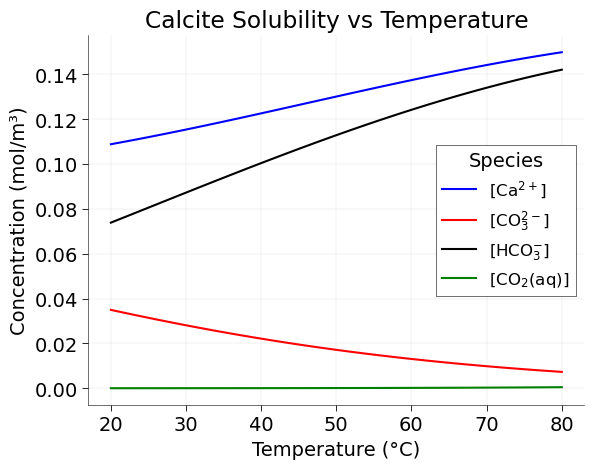

In [7]:
plt.Figure(figsize=(10, 8))

plt.plot(T_range_degC, Ca_concentration, label="[Ca$^{2+}$]", color="C0")
plt.plot(T_range_degC, CO3_concentration, label="[CO$_3^{2-}$]", color="C1")
plt.plot(T_range_degC, HCO3_concentration, label="[HCO$_3^{-}$]", color="C2")
plt.plot(T_range_degC, CO2_concentration, label="[CO$_2$(aq)]", color="C3")

# plt.yscale("log")
plt.xlabel("Temperature (°C)")
plt.ylabel("Concentration (mol/m³)")
plt.title("Calcite Solubility vs Temperature")
plt.legend(title="Species")
plt.grid()
plt.show()

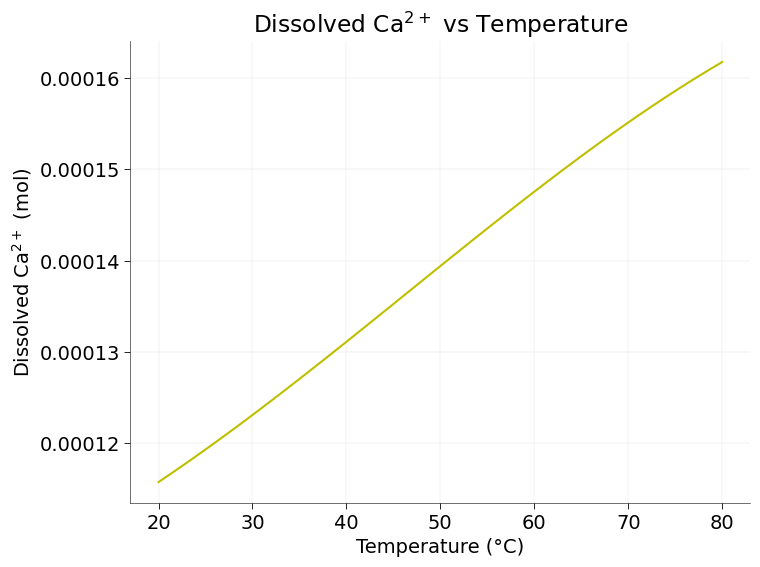

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(T_range_degC, dissolved_caco3, label="Total Ca$^{2+}$ dissolved (mol)", color="C4")
plt.xlabel("Temperature (°C)")
plt.ylabel("Dissolved Ca$^{2+}$ (mol)")
plt.title("Dissolved Ca$^{2+}$ vs Temperature")
plt.grid()
plt.show()

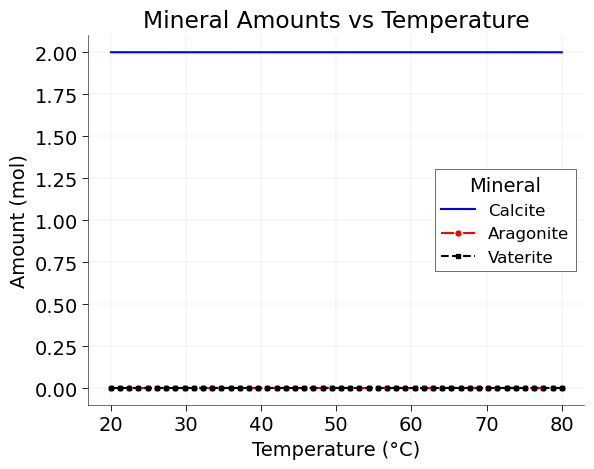

In [9]:
plt.Figure(figsize=(10, 8))
plt.plot(T_range_degC, calcite_amounts, label="Calcite", color="C0")
plt.plot(T_range_degC, aragonite_amounts, label="Aragonite", color="C1", linestyle="-.", marker="o")
plt.plot(T_range_degC, vaterite_amounts, label="Vaterite", color="C2", linestyle="--", marker="s")
plt.xlabel("Temperature (°C)")
plt.ylabel("Amount (mol)")
plt.title("Mineral Amounts vs Temperature")
plt.legend(title="Mineral")
plt.grid()
plt.show()

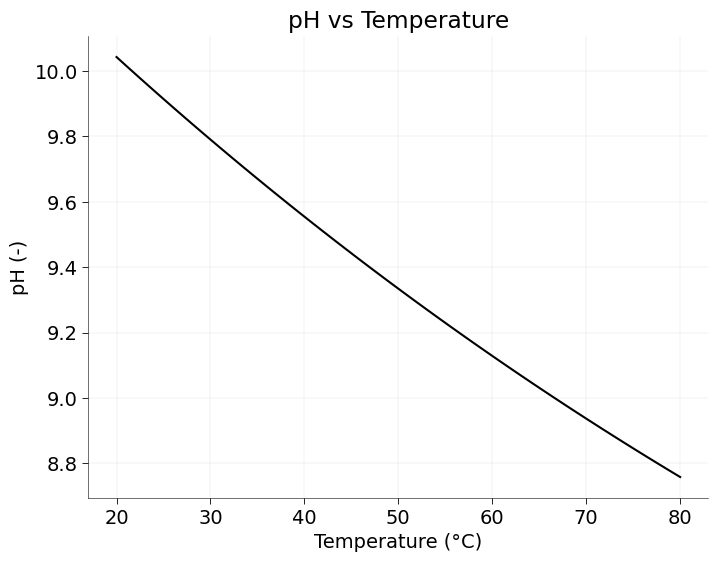

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(T_range_degC, pH_values, label="pH", color="k")
plt.xlabel("Temperature (°C)")
plt.ylabel("pH (-)")
plt.title("pH vs Temperature")
plt.grid()
plt.show()
